/tmp/ipykernel_26423/504210719.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  class_x, class_y = np.random.multivariate_normal(mean, covariance, num_samples).T


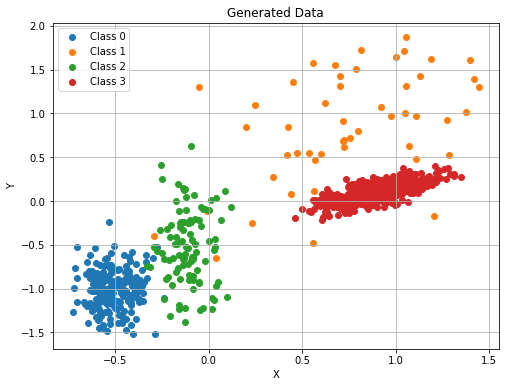

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def generate_data(num_samples_per_class, class_means, class_covariances):
    num_classes = len(num_samples_per_class)
    data = []
    labels = []
    
    for i in range(num_classes):
        mean = class_means[i]
        covariance = class_covariances[i]
        num_samples = num_samples_per_class[i]
        
        # Generate data points for the current class
        class_x, class_y = np.random.multivariate_normal(mean, covariance, num_samples).T
        
        # Append the data points and labels
        data.append(np.vstack((class_x, class_y)).T)
        labels.extend([i] * num_samples)
    
    return np.concatenate(data), np.array(labels)

np.random.seed(202)
torch.manual_seed(202)

# Define parameters for each class
num_samples_per_class = [200, 50, 100, 600]
class_means = [[-0.5, -1], [0.7, 0.7],[-0.1, -0.5],[0.9, 0.1]]
class_covariances = [[[0.01, 0], [0, 0.05]], [[0.2, 0.3], [0, 0.2]], [[0.01, 0], [0, 0.2]],[[0.01, 0.01], [0.02, 0.01]]]

# Generate data
data, labels = generate_data(num_samples_per_class, class_means, class_covariances)

# Plot the data
plt.figure(figsize=(8, 6))
for i in range(len(num_samples_per_class)):
    start = sum(num_samples_per_class[:i])
    end = sum(num_samples_per_class[:i+1])
    plt.scatter(data[start:end, 0], data[start:end, 1], label=f'Class {i}')
plt.title('Generated Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
import torch
from torch.utils.data import TensorDataset

data_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)
dataset = TensorDataset(data_tensor, labels_tensor)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
import torch
from io import BytesIO
from PIL import Image

image_bytes_list = []

def plot_normal_distributions_with_dataset(means_tensor, covariances_tensor, epoch, loss, dataset=None):
    num_gaussians = means_tensor.shape[0]

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot contour lines for each Gaussian distribution
    x = np.linspace(-0.25, 1.25, 100)
    y = np.linspace(-0.25, 1.25, 100)
    X, Y = np.meshgrid(x, y)

    for i in range(num_gaussians):
        mean = means_tensor[i].numpy()
        covariance = covariances_tensor[i].numpy()

        # Calculate probability density function
        pos = np.dstack((X, Y))
        rv = multivariate_normal(mean, covariance)
        Z = rv.pdf(pos)

        # Plot contour lines
        ax.contour(X, Y, Z, levels=5, alpha=0.5)

        # Plot mean point
        ax.plot(mean[0], mean[1], marker='x', markersize=10, label=fr'$\mathcal{{N}}_{i}$')

        # Plot covariance ellipse
        eigenvalues, eigenvectors = np.linalg.eigh(covariance)
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        width, height = 2 * np.sqrt(2 * eigenvalues)
        ellip = Ellipse(xy=mean, width=width, height=height, angle=angle, alpha=0.3)
        ax.add_patch(ellip)

    # Plot dataset if provided
    if dataset is not None:
        data, labels = dataset.tensors
        data = torch.sigmoid(data)
        
        num_classes = torch.max(labels) + 1
        
        # Create a color map for different classes
        cmap = plt.cm.get_cmap('viridis', num_classes)
        
        # Iterate over each class and scatter plot the data points
        for i in range(num_classes):
            class_indices = (labels == i).nonzero().squeeze()
            plt.scatter(data[class_indices, 0], data[class_indices, 1], c=[cmap(i)], label=f'Class {i}')

    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['axes.labelsize'] = 15
    plt.rcParams['legend.fontsize'] = 15
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Epoch=%d, L1=%.3f' % (epoch,loss))
    ax.legend(fontsize=15, loc='upper right')
    ax.grid(True)
    plt.show()
    image_stream = BytesIO()
    plt.savefig(image_stream, format='png')
    plt.close(fig)
    if epoch in [0, 25, 50, 100]:
        fig.savefig('test_{}.pdf'.format(epoch), format='pdf',bbox_inches='tight')
    
    # Append the byte stream to the global list
    image_bytes_list.append(image_stream.getvalue())

def create_gif(output_gif):
    images = [Image.open(BytesIO(image_bytes)) for image_bytes in image_bytes_list]
    gif_duration = 1000  # milliseconds
    images[0].save(output_gif, save_all=True, append_images=images[1:], optimize=False, duration=gif_duration, loop=0)


In [ ]:
from dlquantification.featureextraction.nofe import NoFeatureExtractionModule
from dlquantification.featureextraction.fullyconnected import FCFeatureExtractionModule
from dlquantification.gmnet import GMNet
from dlquantification.utils.utils import APPBagGenerator


device = torch.device("cpu")
fe = NoFeatureExtractionModule(input_size=2)
#fe = FCFeatureExtractionModule(input_size=2,output_size=2,hidden_sizes=[4])

gmnet = GMNet(
    train_epochs=101,
    test_epochs=1,
    n_classes=4,
    start_lr=0.001,
    end_lr=0.001,
    n_bags=500,
    bag_size=50,
    n_gm_layers=1,
    num_gaussians=[3],
    gaussian_dimensions=[None],
    random_seed=2032,
    linear_sizes=[4],
    feature_extraction_module=fe,
    bag_generator=APPBagGenerator(device=device),
    val_bag_generator=APPBagGenerator(device=device),
    batch_size=10,
    quant_loss=torch.nn.L1Loss(),
    lr_factor=0.2,
    patience=20,
    dropout=0,
    epsilon=0,
    weight_decay=0,
    use_labels=False,
    val_split=0,
    device=device,
    verbose=1,
    dataset_name="test_gmnet_2D",
)

def callback_epoch(val_loss, epoch):
    # print("Epoch %d validation loss: %f" % (epoch, val_loss))
    print("Means:")
    print(gmnet.model.quantmodule.gm_modules[0].gm_layer_0.centers)
    # print("Covariance matrix:")
    # print(gmnet.model.quantmodule.layers.gm_layer_0.covariance)
    
    plot_normal_distributions_with_dataset(gmnet.model.quantmodule.gm_modules[0].gm_layer_0.centers.detach(),gmnet.model.quantmodule.gm_modules[0].gm_layer_0.covariance.detach(),epoch, val_loss,dataset=dataset)

gmnet.callback_epoch = callback_epoch
print("Means:")
print(gmnet.model.quantmodule.gm_modules[0].gm_layer_0.centers)
gmnet.fit(dataset)
output_gif = 'output.gif'
create_gif(output_gif)